In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats.anova import AnovaRM

### Load and parse
Remove subjects without good (fd < 0.2mm) data for all conditions (or missing runs)

In [16]:
# load data
df = pd.read_csv("data/mean_fd_n184.csv")
n = df["sub"].unique().shape[0]
# select subjects with MOVIE 1-4, and REST 1-4
df = df.query("condition == 'MOVIE1' | condition == 'MOVIE2' | condition == 'MOVIE3' | condition == 'MOVIE4' | condition == 'REST1' | condition == 'REST2' | condition == 'REST3' | condition == 'REST4'")

# set runs with mean_fd > 0.2mm to NaN
#print(sum(df['mean_fd']>0.2)/df.shape[0])
df.loc[df['mean_fd'] > 0.2, "mean_fd"] = np.NaN

# remove subjects with any nans (runs >0.2mm FD)
df_sub = df.pivot(index="sub", columns=["condition"]).dropna()
print(f'Dropped {n - df_sub.shape[0]}/{n} subjects with missing values')
df.drop(index=df.index[~df['sub'].isin(df_sub.index)], inplace=True)
#for i in df["sub"].unique():
    #print(i)
n = df_sub.shape[0]
print(f'n={n} subjects')
# export subject list
with open(f'data/sub_n{n}.csv', 'w') as f:
    for i in df_sub.index:
        f.write("%s\n" % i)

Dropped 86/184 subjects with missing values
n=98 subjects


### Motion analysis

                 Anova
          F Value Num DF  Den DF  Pr > F
----------------------------------------
condition 21.2036 7.0000 679.0000 0.0000



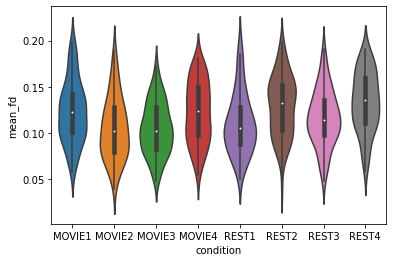

In [17]:
# plot
ax = sns.violinplot(y="mean_fd", x="condition", data=df)

# RM-ANOVA to see if condition has significant effect on motion
mdl = AnovaRM(data=df, depvar="mean_fd", subject="sub", within=["condition"])
print(mdl.fit())

# paired t-test by averaging MOVIE and REST


### Scrubbing analysis
Look at how number of vol threshold affects # of subjects

95 subjects remain with all runs > 480 volumes


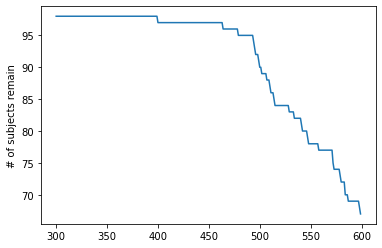

In [18]:
df_scrub = pd.read_csv("data/sub_n98_mean_fd.csv")
conds = ["movie1", "movie2", "movie3", "movie4", "rest1", "rest2", "rest3", "rest4"]
for c in conds:
    df_tmp = pd.read_csv(f'data/sub_vols_{c}.csv')
    df_scrub = pd.merge(df_scrub,df_tmp,on="sub")

# look across range of thresholds (and plot)
n = []
for thresh in range(300,600):
    tmp = df_scrub.query(f'vol_m1 > {thresh} & vol_m2 > {thresh} & vol_m3 > {thresh} & vol_m4 > {thresh} & vol_r1 > {thresh} & vol_r2 > {thresh} & vol_r3 > {thresh} & vol_r4 > {thresh}')
    n.append(tmp.shape[0])
plt.plot(range(300,600),n)
plt.ylabel('# of subjects remain')

# select threshold
thresh = 480
df_scrub = df_scrub.query(f'vol_m1 > {thresh} & vol_m2 > {thresh} & vol_m3 > {thresh} & vol_m4 > {thresh} & vol_r1 > {thresh} & vol_r2 > {thresh} & vol_r3 > {thresh} & vol_r4 > {thresh}')
print(f'{df_scrub.shape[0]} subjects remain with all runs > {thresh} volumes')


### Check for movie vs. rest volume differences

Ttest_relResult(statistic=-46.928564168928325, pvalue=4.918761260142599e-67)


,sub,vol_m1,vol_m2,vol_m3,vol_m4,vol_r1,vol_r2,vol_r3,vol_r4,vol_movie_sum,vol_rest_sum,vol_diff
40,195041,635,529,660,628,896,879,897,896,2452,3568,1116
68,581450,673,696,641,494,896,896,888,863,2504,3543,1039
39,193845,654,670,604,656,892,900,879,880,2584,3551,967
70,638049,639,615,641,680,900,886,896,838,2575,3520,945
37,192439,630,658,661,687,900,900,872,900,2636,3572,936
...,...,...,...,...,...,...,...,...,...,...,...,...
24,169040,547,633,655,667,873,595,556,900,2502,2924,422
1,105923,663,704,671,683,789,621,862,865,2721,3137,416
95,951457,615,688,671,687,896,714,842,610,2661,3062,401
22,165436,642,692,541,607,772,827,679,602,2482,2880,398


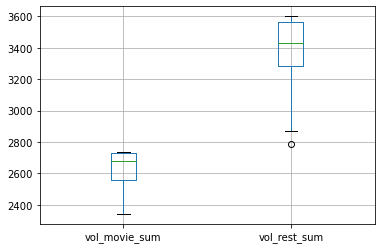

In [19]:
# make combined rest (1-4) and movie (1-4) variables
df_scrub["vol_movie_sum"] = df_scrub["vol_m1"] + df_scrub["vol_m2"] + df_scrub["vol_m3"] + df_scrub["vol_m4"] 
df_scrub["vol_rest_sum"] = df_scrub["vol_r1"] + df_scrub["vol_r2"] + df_scrub["vol_r3"] + df_scrub["vol_r4"] 

# perform paired t-test
print(scipy.stats.ttest_rel(df_scrub["vol_movie_sum"], df_scrub["vol_rest_sum"], axis=0, nan_policy='propagate', alternative='two-sided'))

# boxplot of combined rest(1-4) and movie(1-4) number of volumes
boxplot = df_scrub.boxplot(column=['vol_movie_sum', 'vol_rest_sum'])

# look at people with biggest movie / rest differences (hopefully not necessary)
df_scrub['vol_diff'] = np.abs(df_scrub['vol_rest_sum']-df_scrub['vol_movie_sum'])
df_scrub.sort_values("vol_diff",ascending=False)

In [21]:
df_scrub.to_csv("final_n95_vols.csv")